In [4]:
!pip install git+https://github.com/messari/messari-python-api.git
!pip install pmdarima

  Cloning https://github.com/messari/messari-python-api.git to /private/var/folders/ks/0nlmbx4j0rg3pzjsgw_7b7rw0000gn/T/pip-req-build-sda3x62f
  Running command git clone -q https://github.com/messari/messari-python-api.git /private/var/folders/ks/0nlmbx4j0rg3pzjsgw_7b7rw0000gn/T/pip-req-build-sda3x62f
  Resolved https://github.com/messari/messari-python-api.git to commit 79a204e6a12111402833287e4fdbdb088d22fa4a


In [5]:
from messari.messari import Messari

messari = Messari()
assets = ['bitcoin']
metric = 'price'
start = '2020-01-01'
end = '2023-01-01'
df = messari.get_metric_timeseries(asset_slugs=assets, asset_metric=metric, start=start, end=end)
df = df[f'{assets[0]}']


In [6]:
from sklearn.model_selection import train_test_split

period = 7
dates = df.reset_index()['timestamp'].tolist()
close = df['close'].tolist()
train, test = train_test_split(close, test_size=period, shuffle=False)
train_dates, test_dates = train_test_split(dates, test_size=period, shuffle=False)
train, val = train_test_split(train, test_size=period, shuffle=False)
train_dates, val_dates = train_test_split(train_dates, test_size=period, shuffle=False)

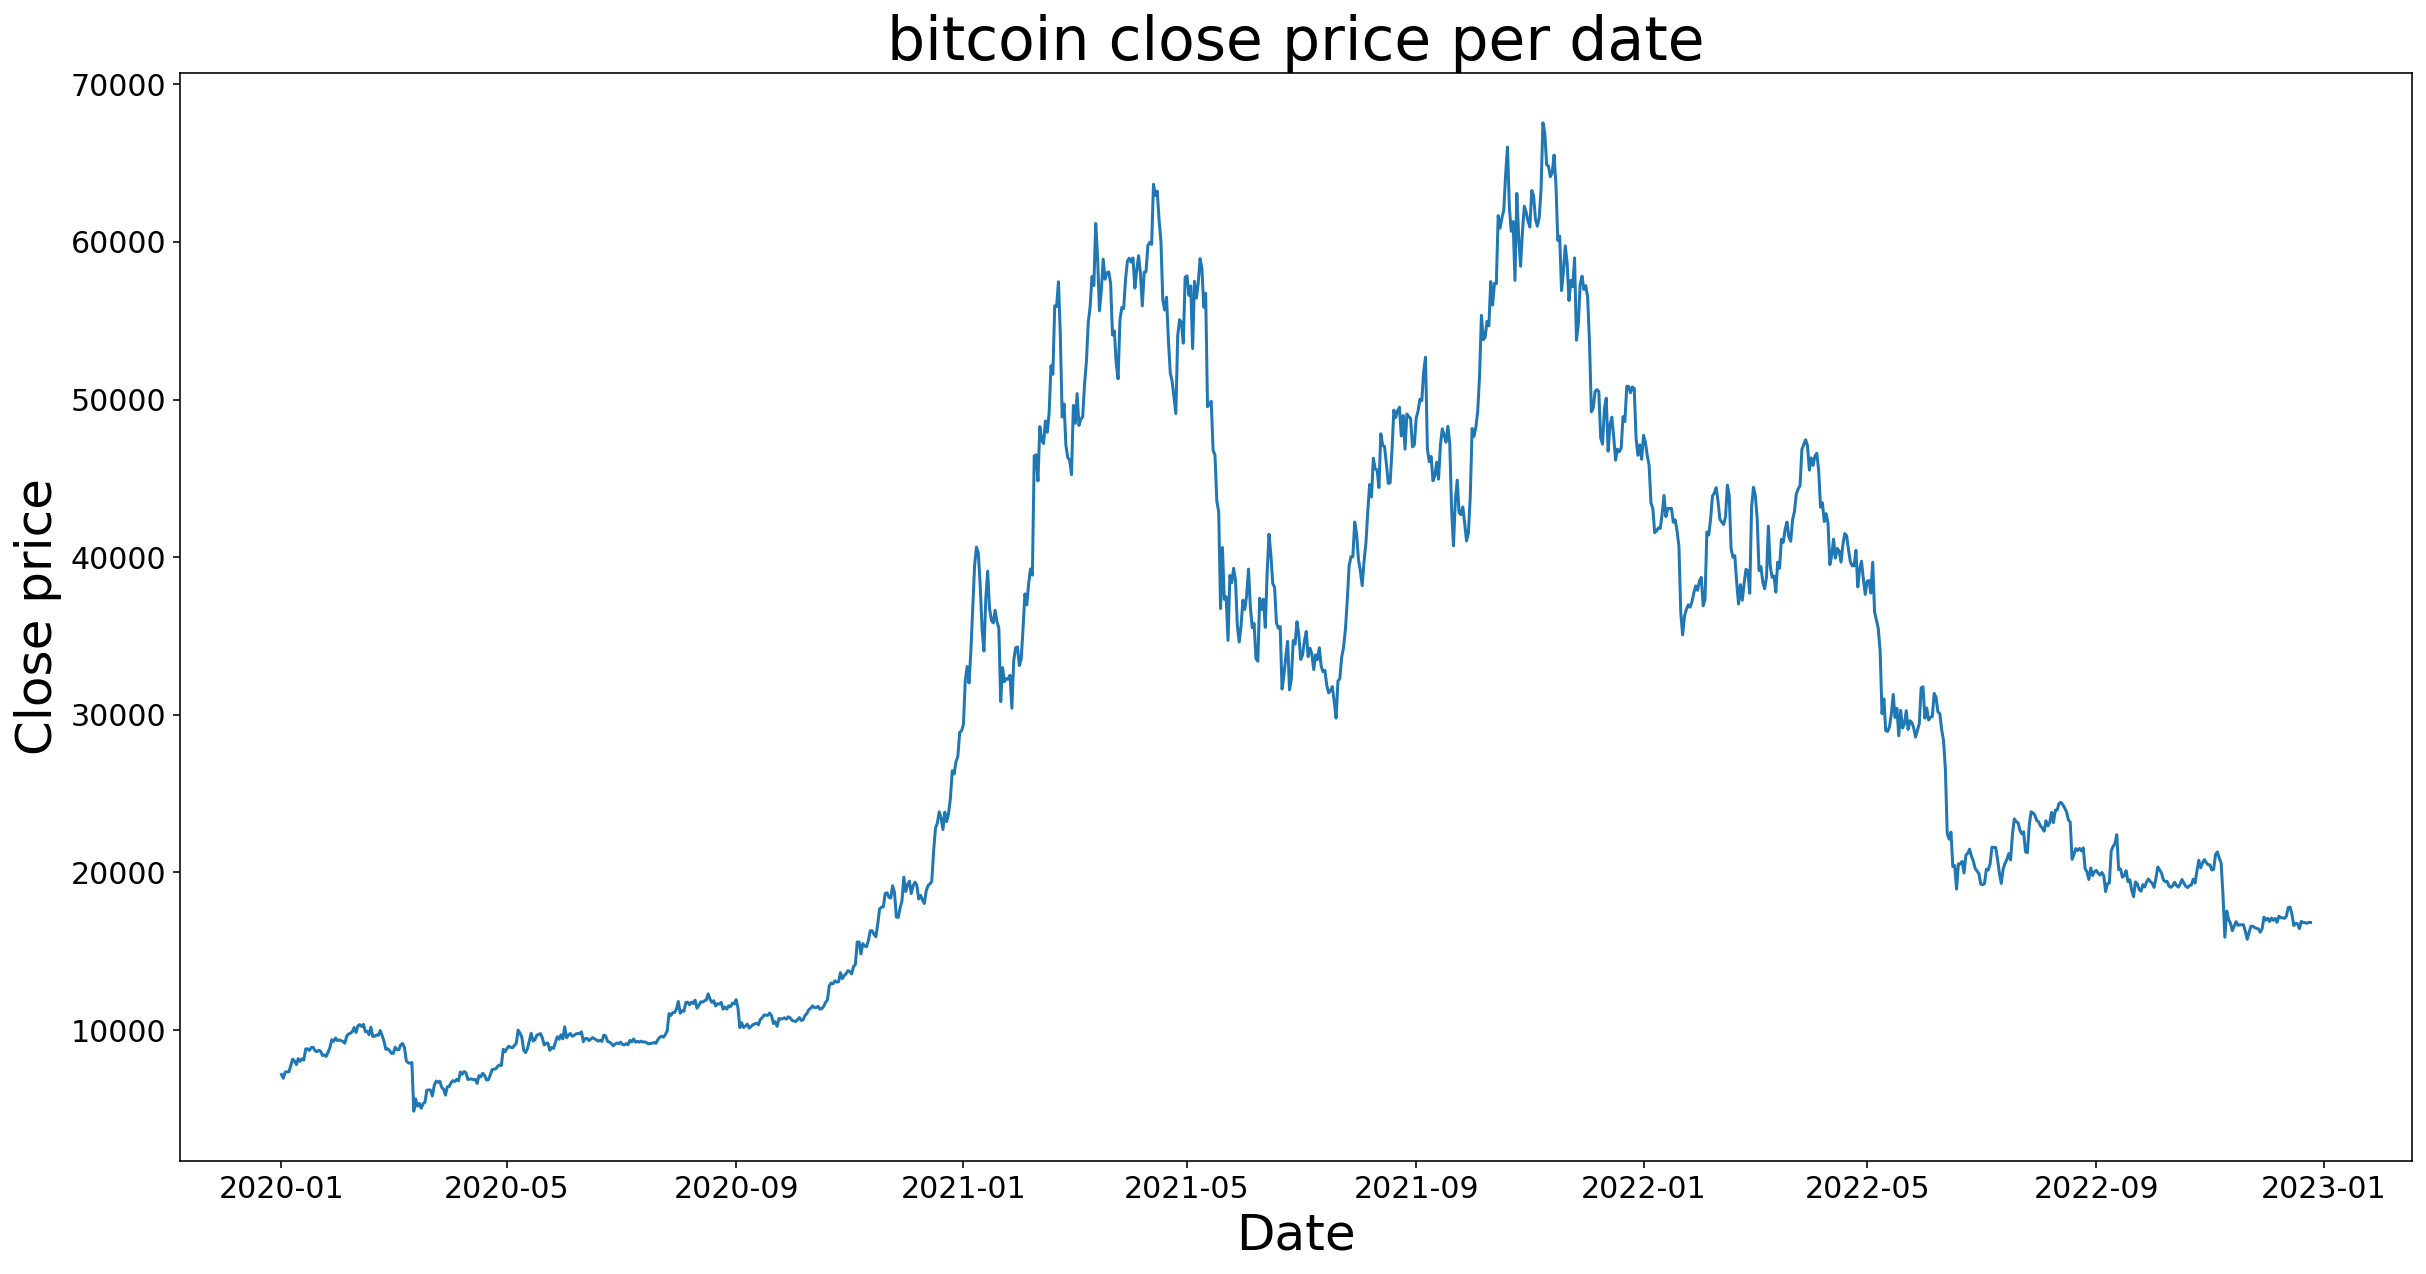

In [7]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 20, 10
plt.plot(train_dates+val_dates, train+val)
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.title(f"{assets[0]} close price per date", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

d = 0
if adfuller(train)[1] >= 0.05:
    print('Data is not stationary')
    d += 1
else:
    print('Data is stationary')

Data is not stationary


### Auto ARIMA implementation. ###

In [9]:
from pmdarima.arima import auto_arima

model = auto_arima(train+val, max_p=5, d=d, max_q=15, max_order=30, seasonal=False, stepwise=False)
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1090
Model:               SARIMAX(2, 1, 4)   Log Likelihood               -9344.569
Date:                Mon, 01 May 2023   AIC                          18705.139
Time:                        23:18:30   BIC                          18745.083
Sample:                             0   HQIC                         18720.258
                               - 1090                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.0220     97.090      0.083      0.934    -182.271     198.314
ar.L1         -0.4748      0.015    -31.596      0.000      -0.504      -0.445
ar.L2         -0.9613      0.015    -64.727      0.0

In [10]:
auto_arima_order = (model.get_params()['order'])
auto_arima_order

(2, 1, 4)

In [11]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(period)
RMSE = mean_squared_error(test, y_pred, squared=False)
rel_error = ((abs(y_pred - test)) / test) * 100

print("RMSE = %.3f" % RMSE, sep="")
print("Relative error = %.3f" % rel_error.mean(), '%', sep="")
print("Last relative error = %.3f" % rel_error[-1], '%', sep="")

RMSE = 236.481
Relative error = 1.345%
Last relative error = 1.443%


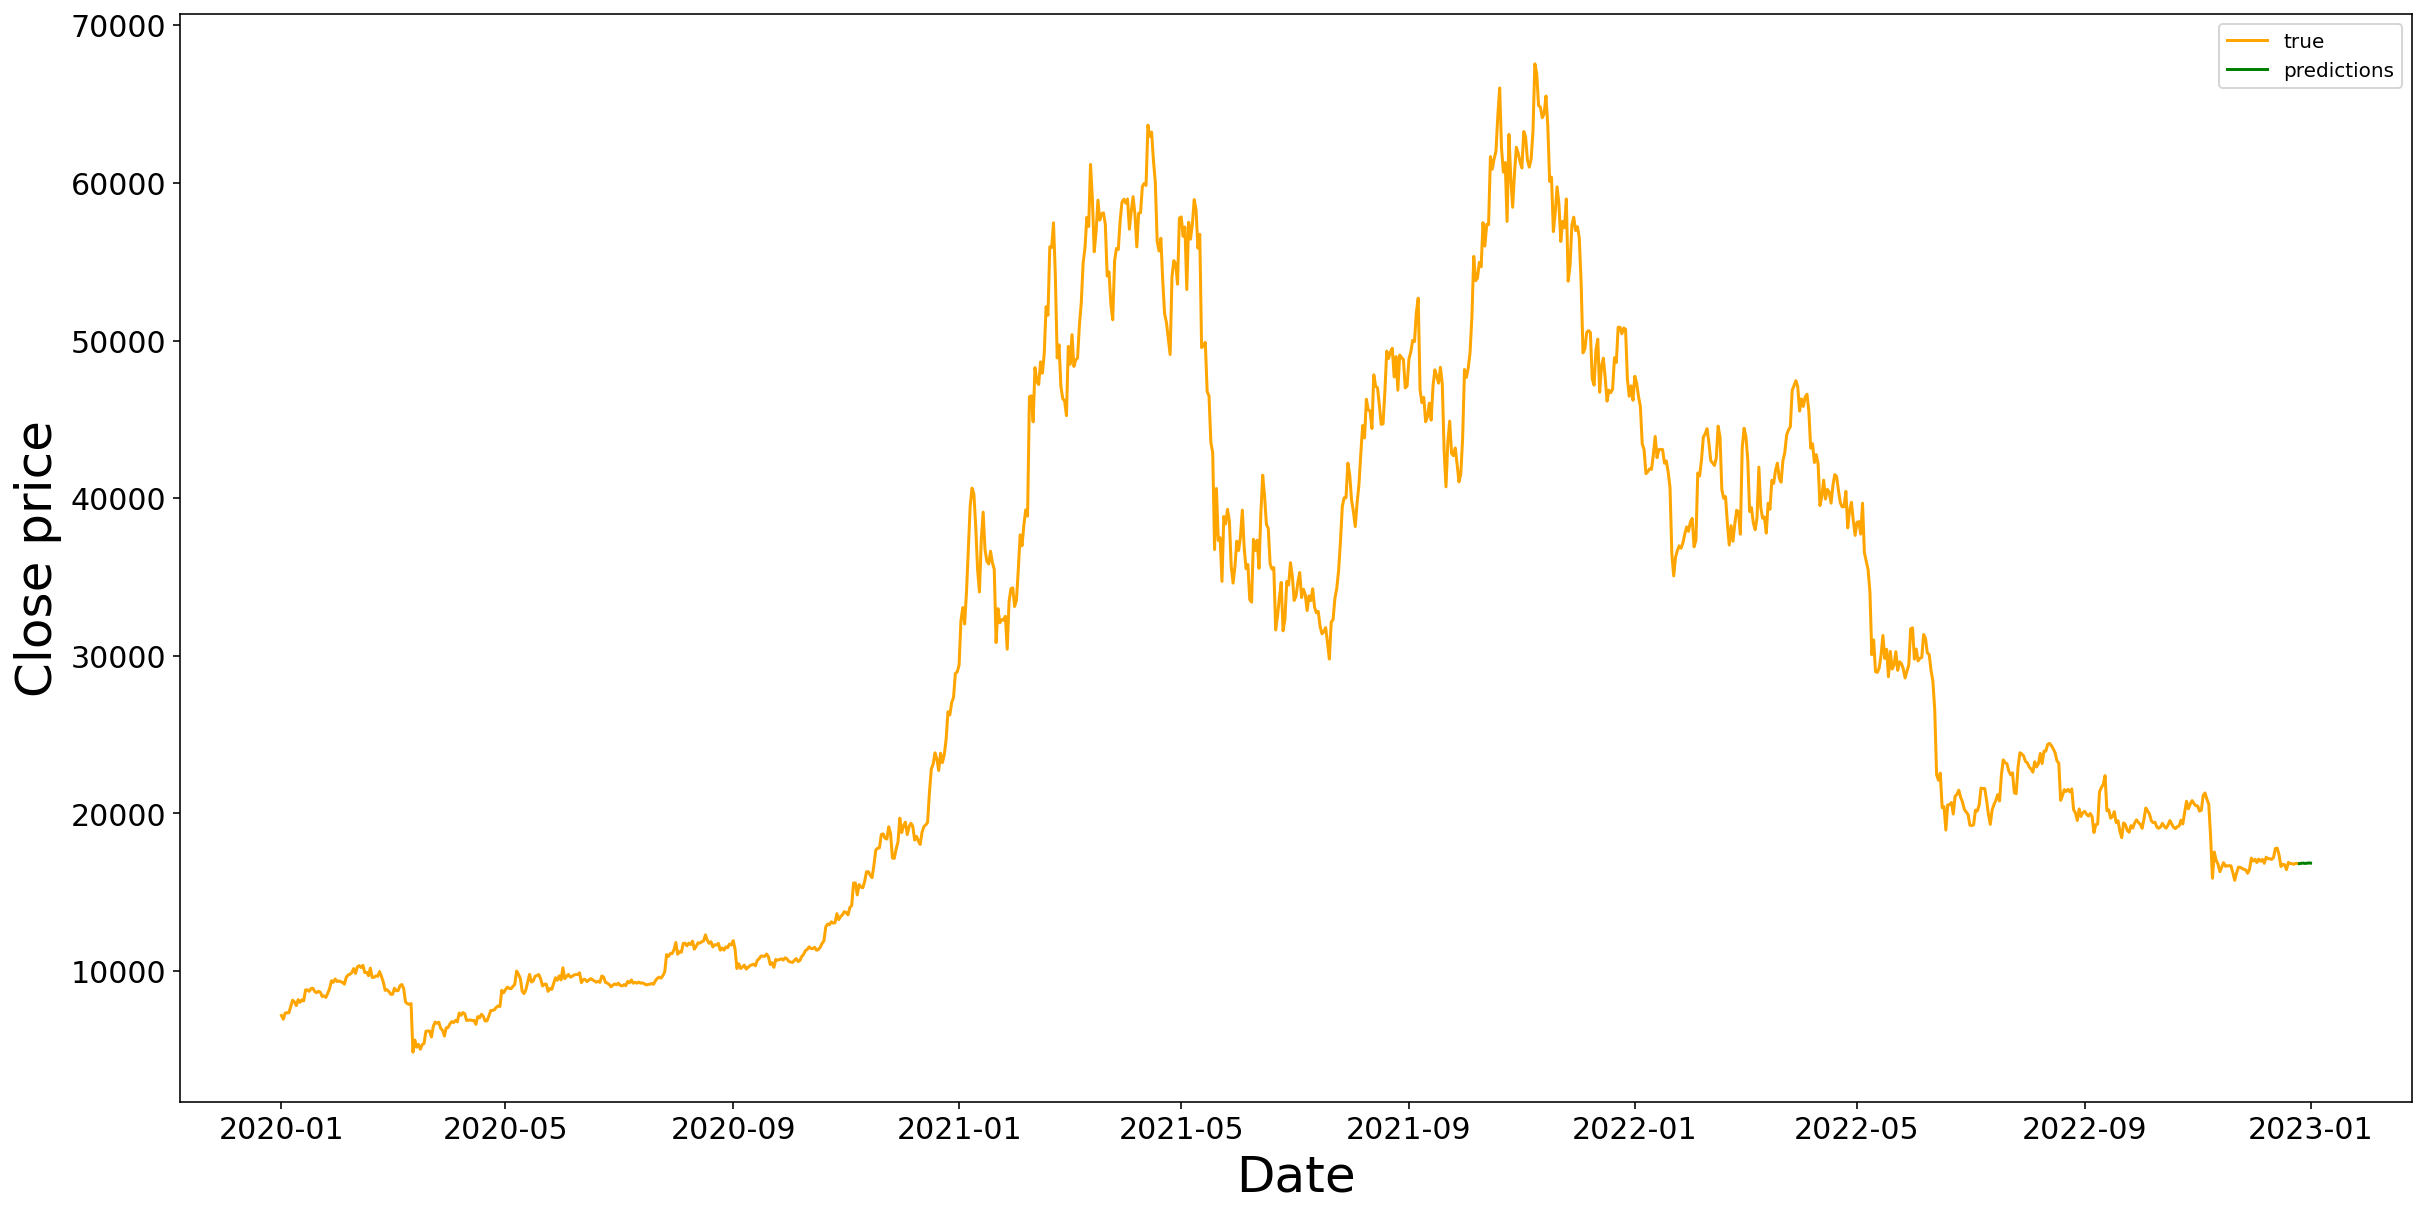

In [12]:
plt.plot(train_dates+val_dates, train+val, color = 'orange', label = 'true')
plt.plot(test_dates, y_pred, color = 'green', label = 'predictions')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

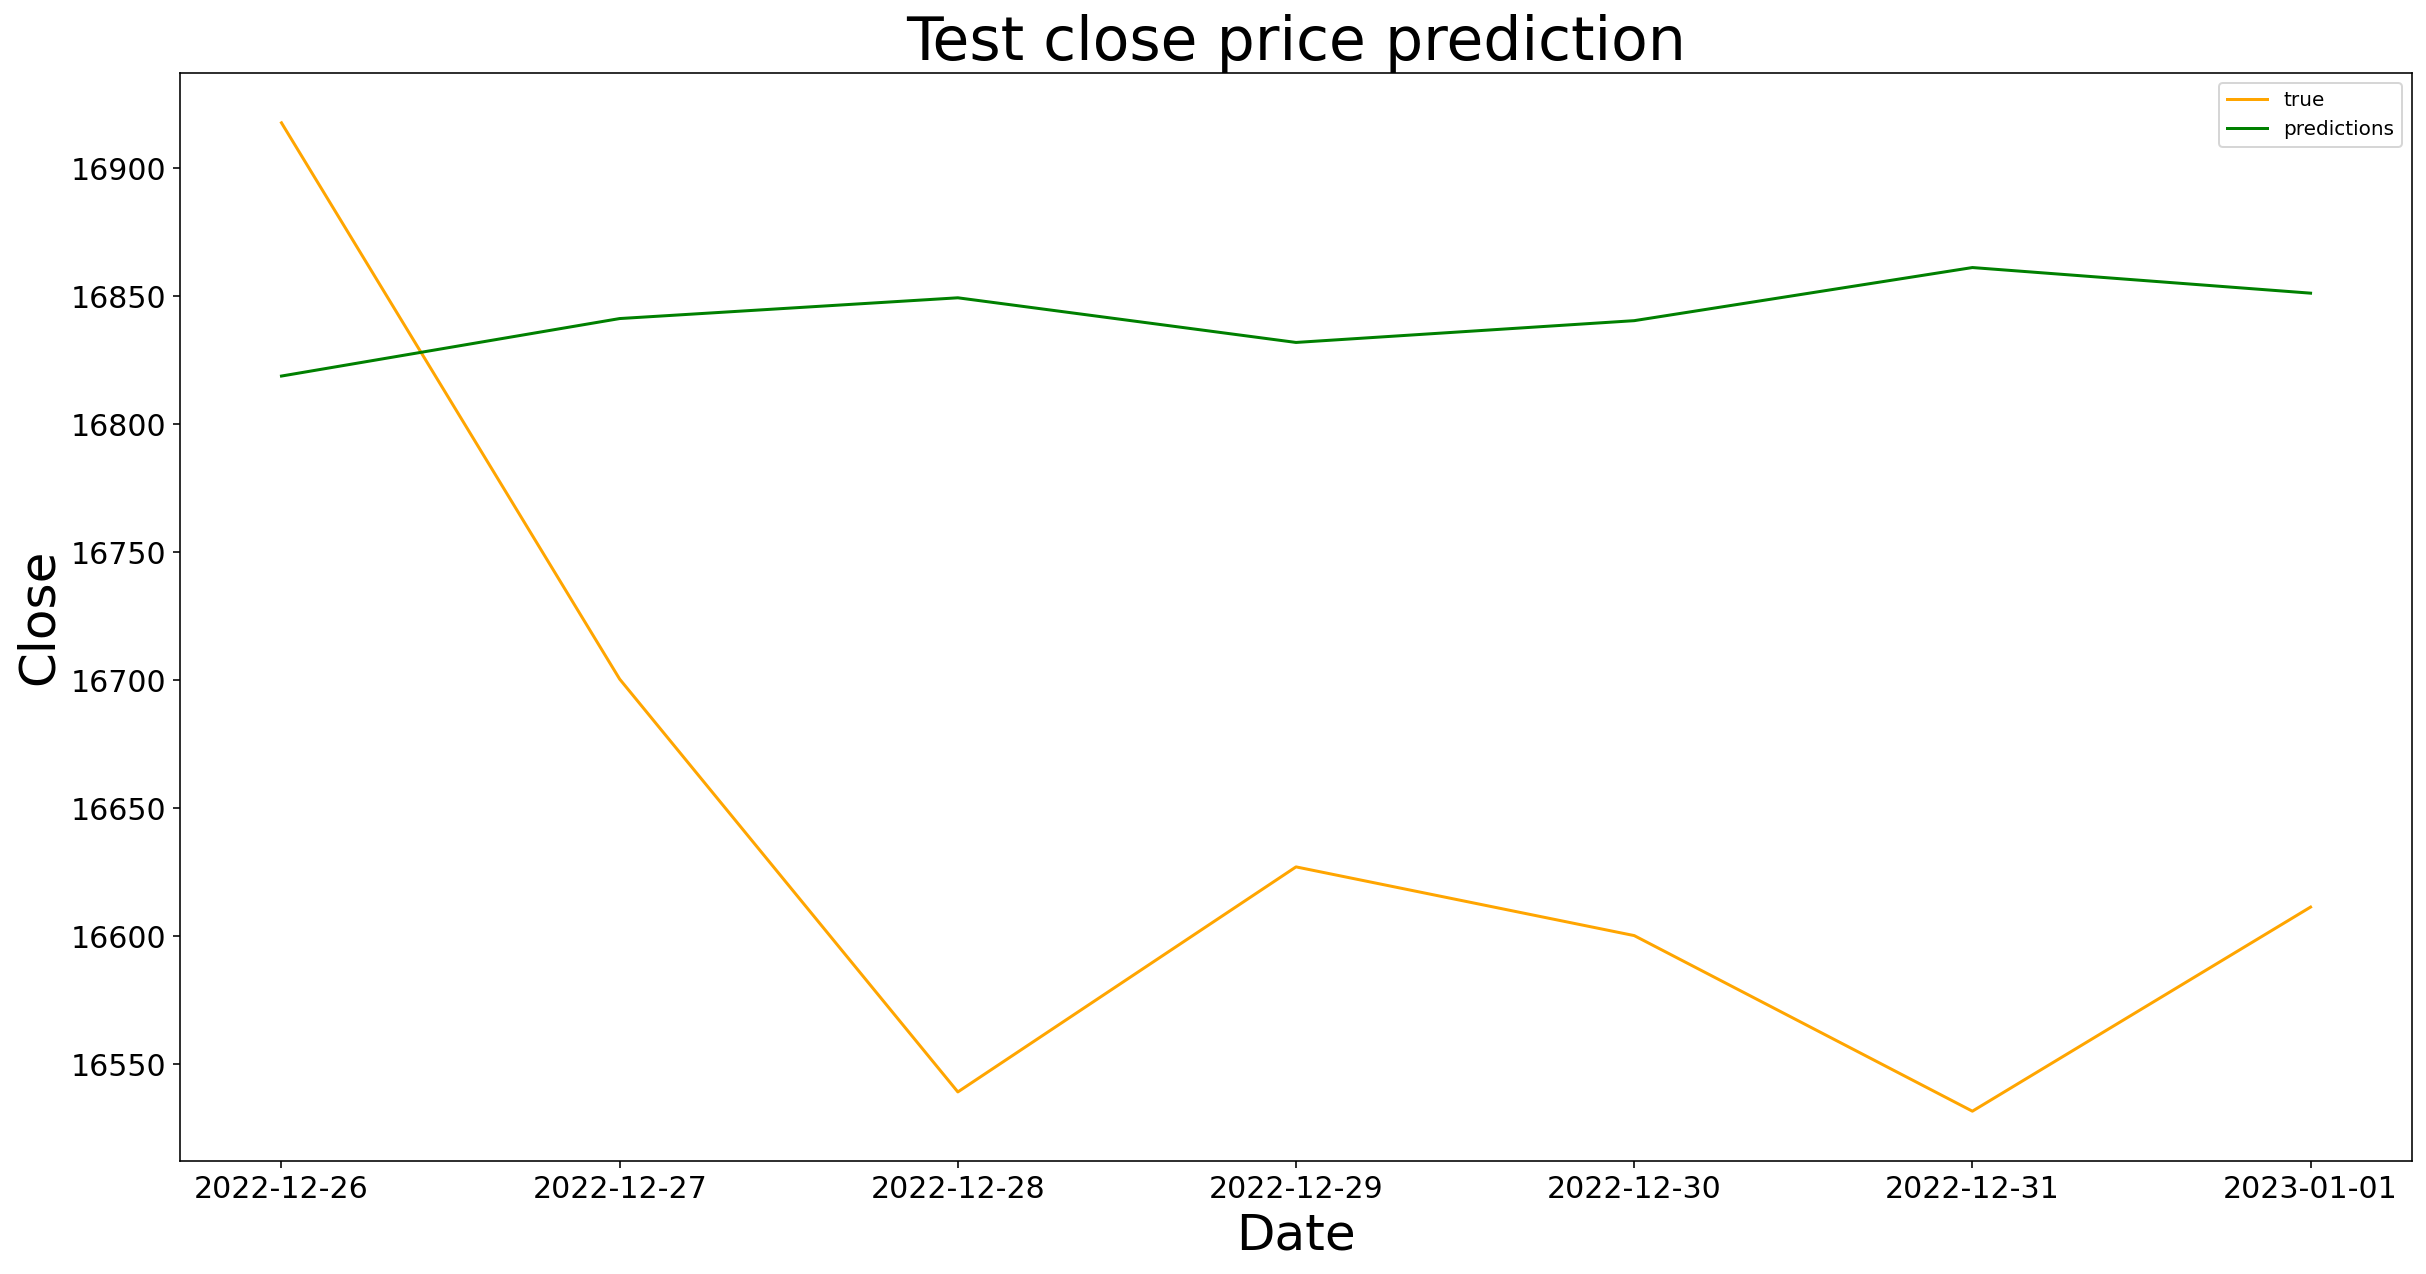

In [13]:
plt.plot(test_dates, test, color = 'orange', label = 'true')
plt.plot(test_dates, y_pred, color = 'green', label = 'predictions')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close", fontsize = 25)
plt.title("Test close price prediction", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

### Now lets try to get p, d, r parameters with grid search. ###

/Users/alexander/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


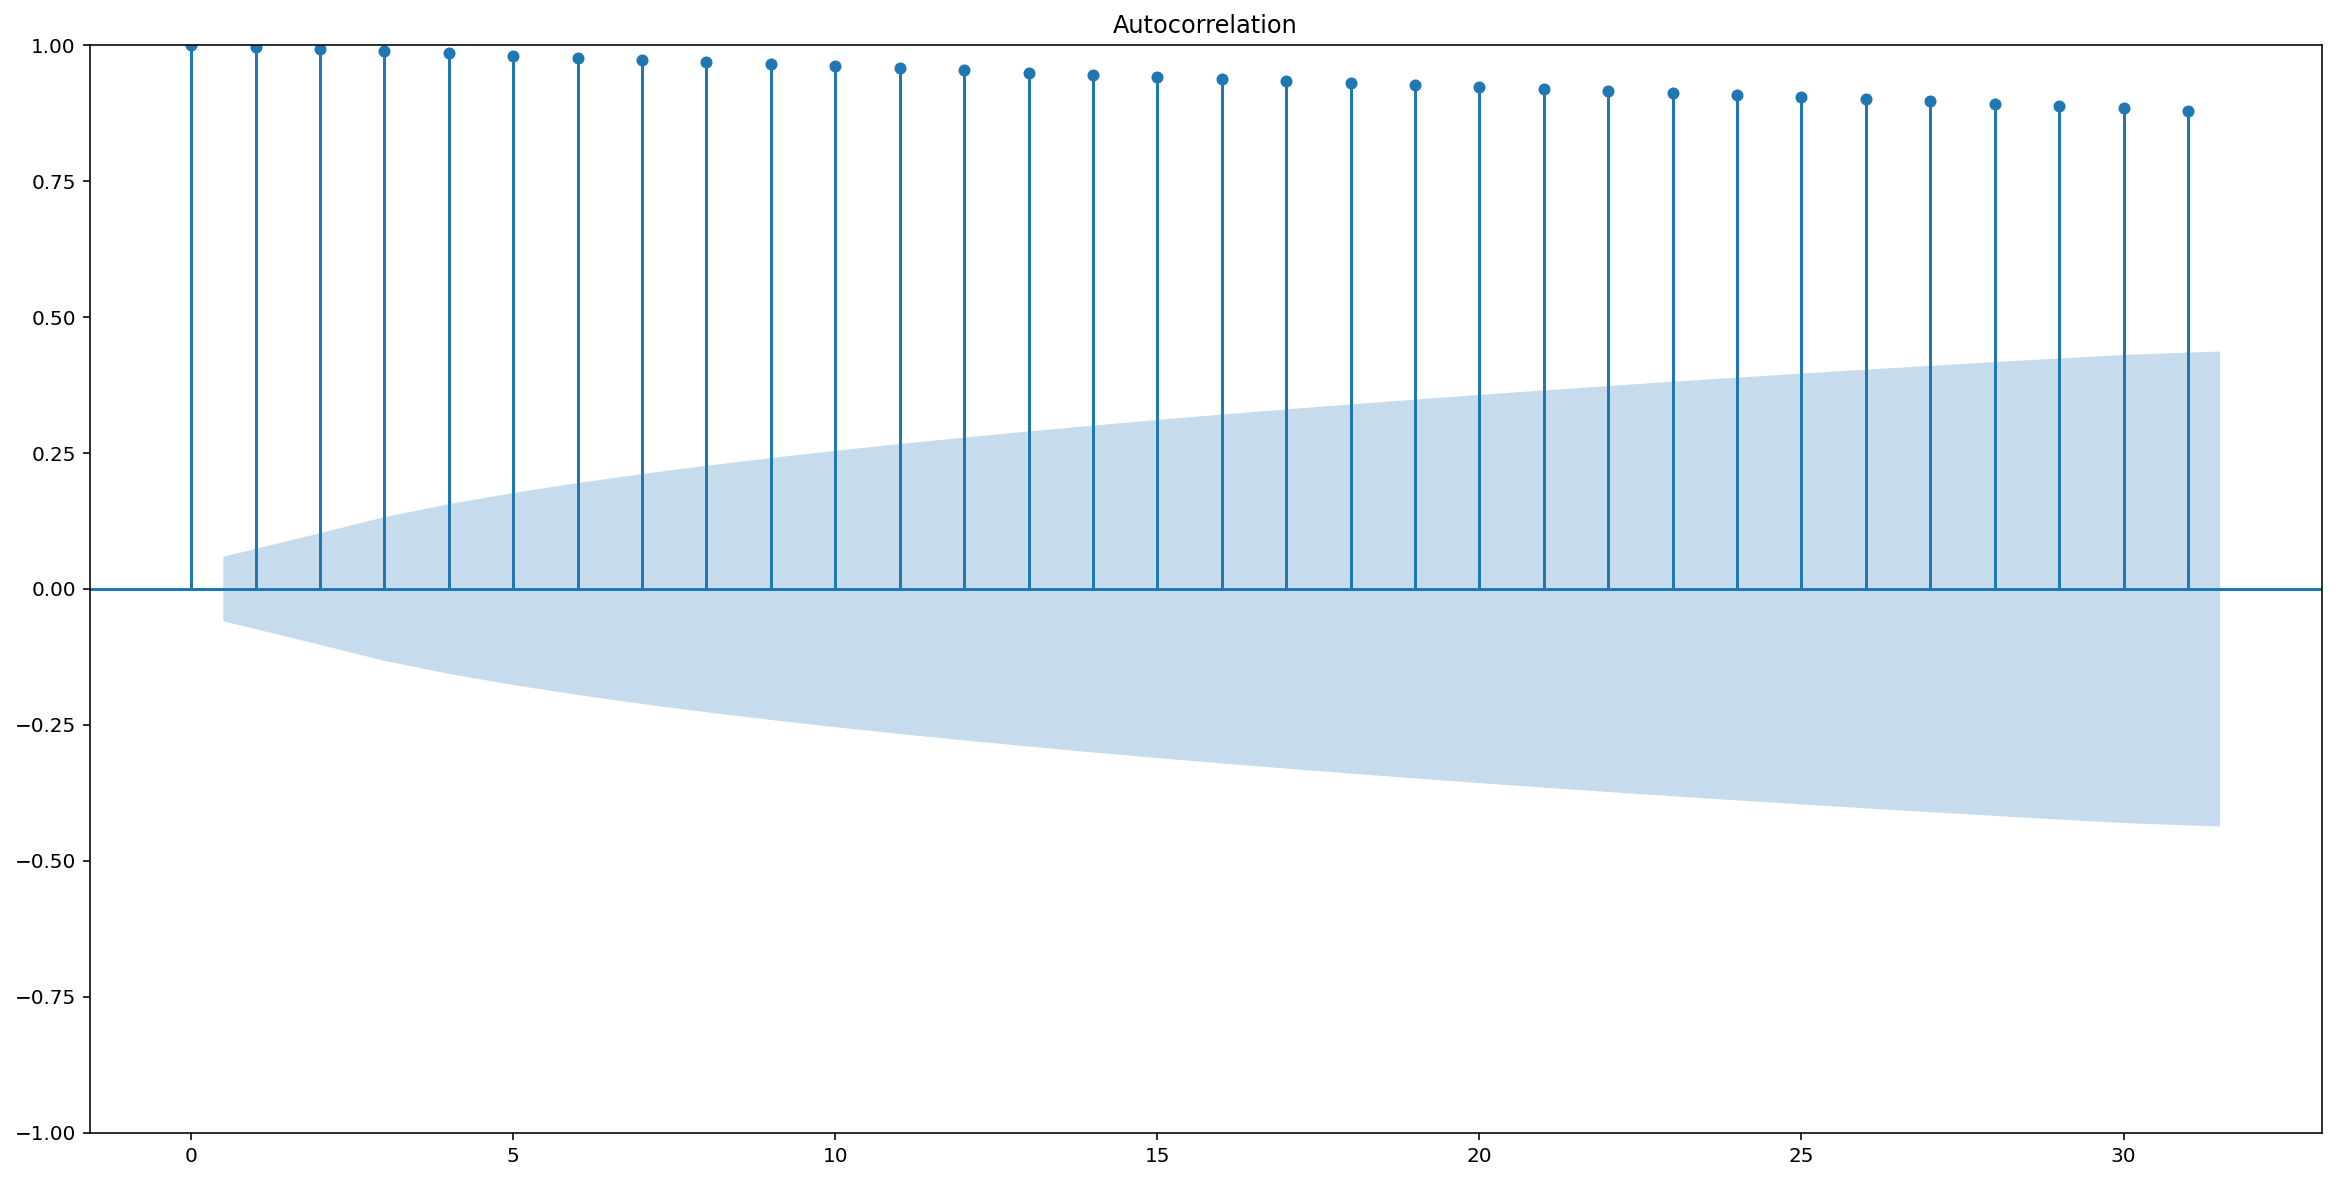

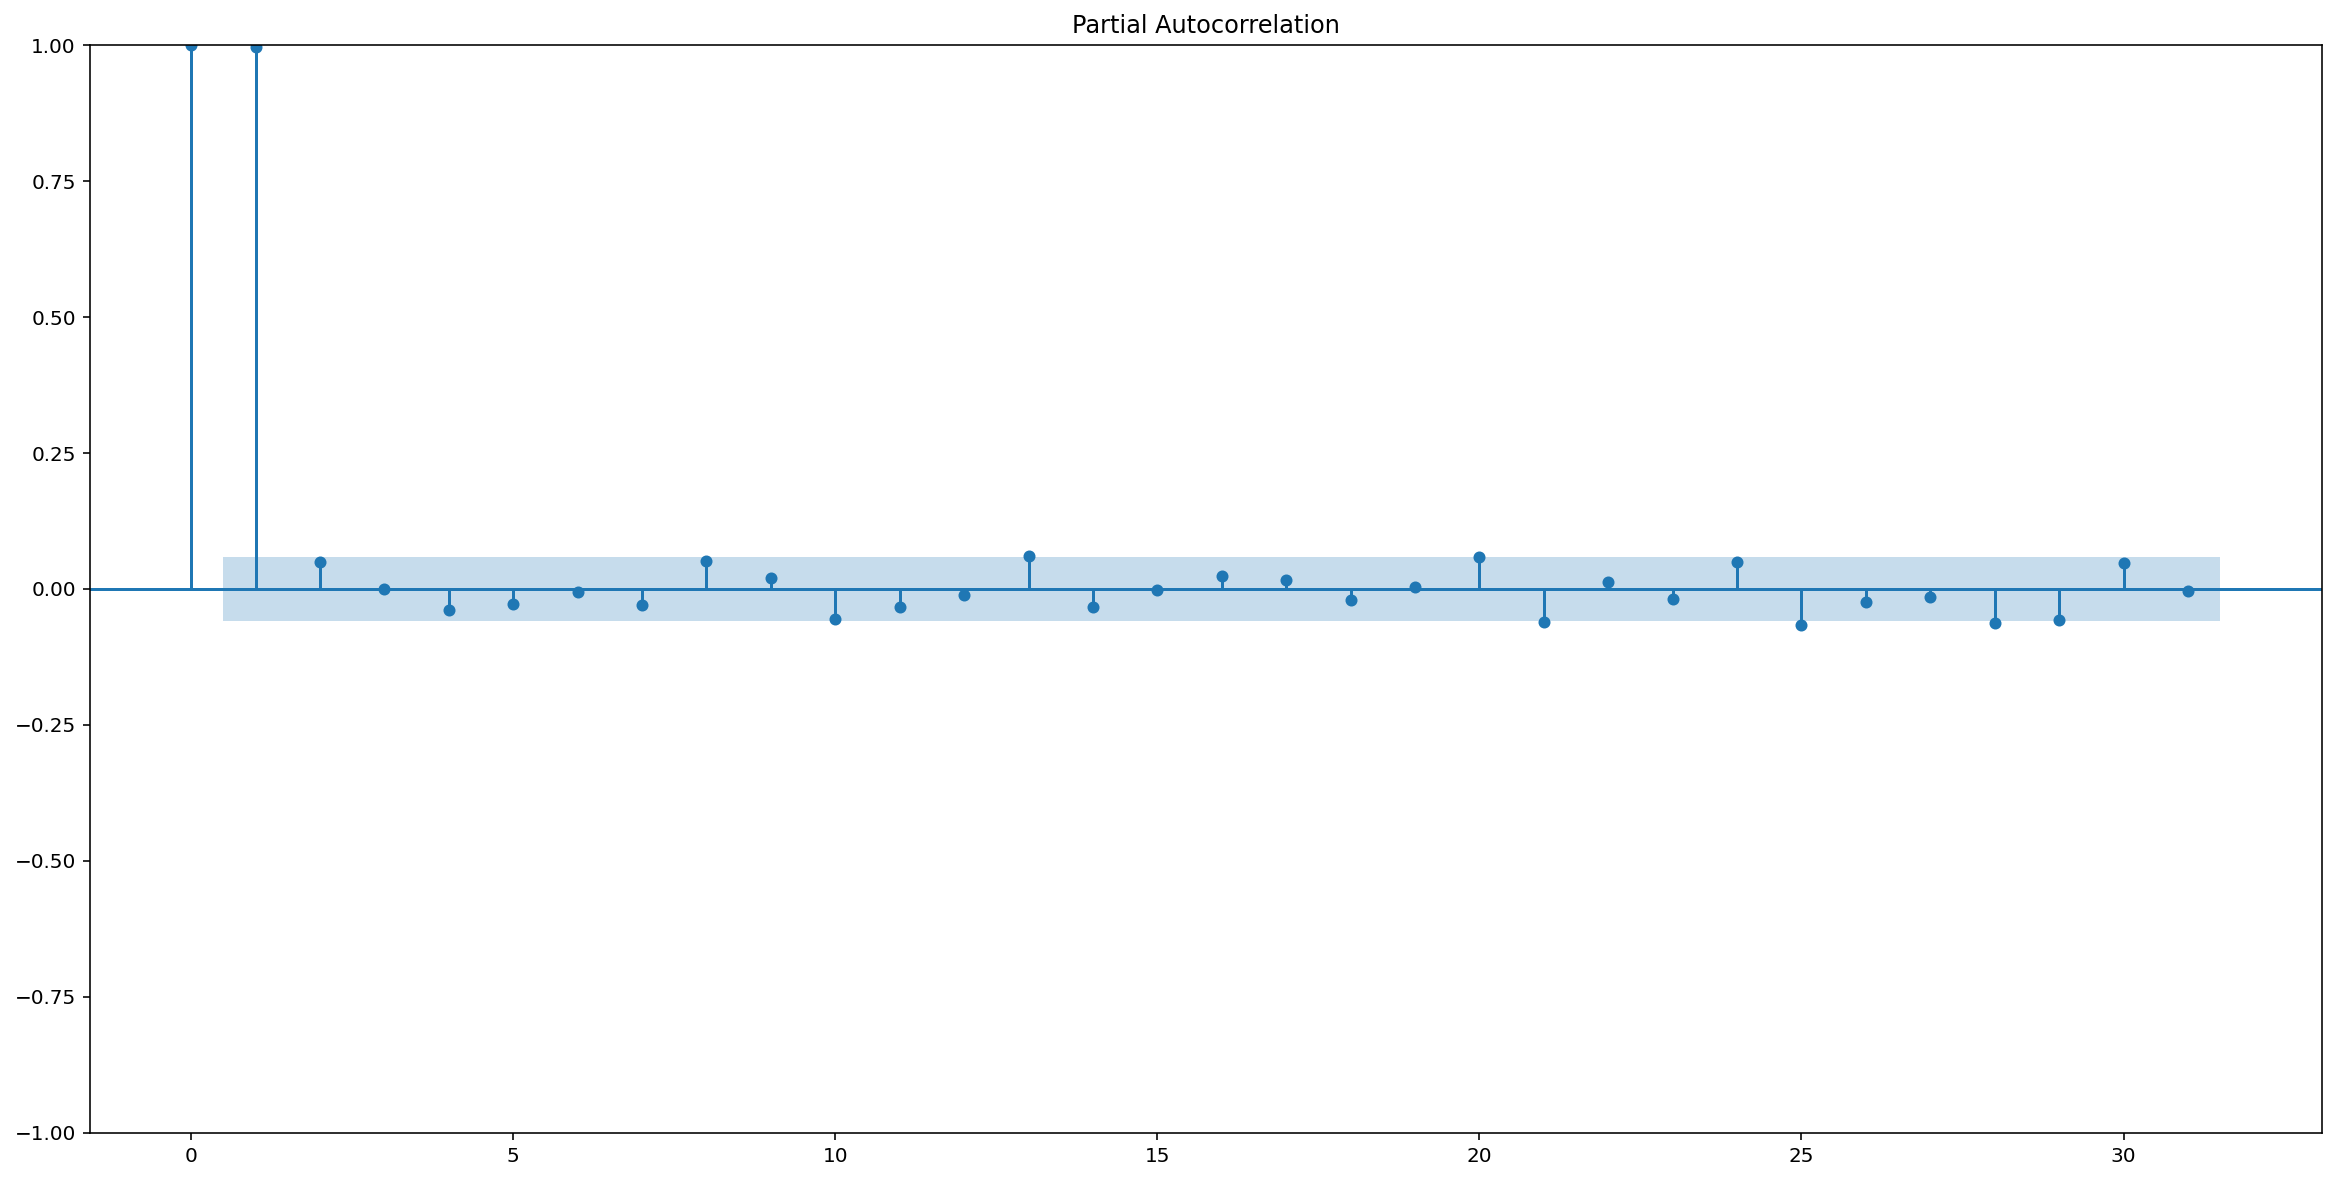

In [14]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plot_acf(df['close'][:-period])
plot_pacf(df['close'][:-period])
plt.show()

In [15]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
import numpy as np

p_values = range(0, 6)
q_values = range(0, 16)
best_rmse = np.inf
arima_order = (0, 0, 0)

for p in p_values:
    for q in q_values:
        warnings.filterwarnings("ignore")
        order = (p,d,q)
        model_ = ARIMA(train, order=order).fit()
        y_pred_ = model_.forecast(period)
        rmse = mean_squared_error(val, y_pred_, squared=False)
        if rmse < best_rmse:
            best_rmse = rmse
            arima_order = order

arima_order

(4, 1, 6)

In [16]:
model_ = ARIMA(train+val, order=arima_order).fit()
y_pred_ = model_.forecast(period)
RMSE_ = mean_squared_error(test, y_pred_, squared=False)
rel_error_ = ((abs(y_pred_ - test)) / test) * 100
print("RMSE = %.3f" % RMSE_, sep="")
print("Relative error = %.3f" % rel_error_.mean(), '%', sep="")
print("Last relative error = %.3f" % rel_error_[-1], '%', sep="")

RMSE = 192.566
Relative error = 1.028%
Last relative error = 1.368%


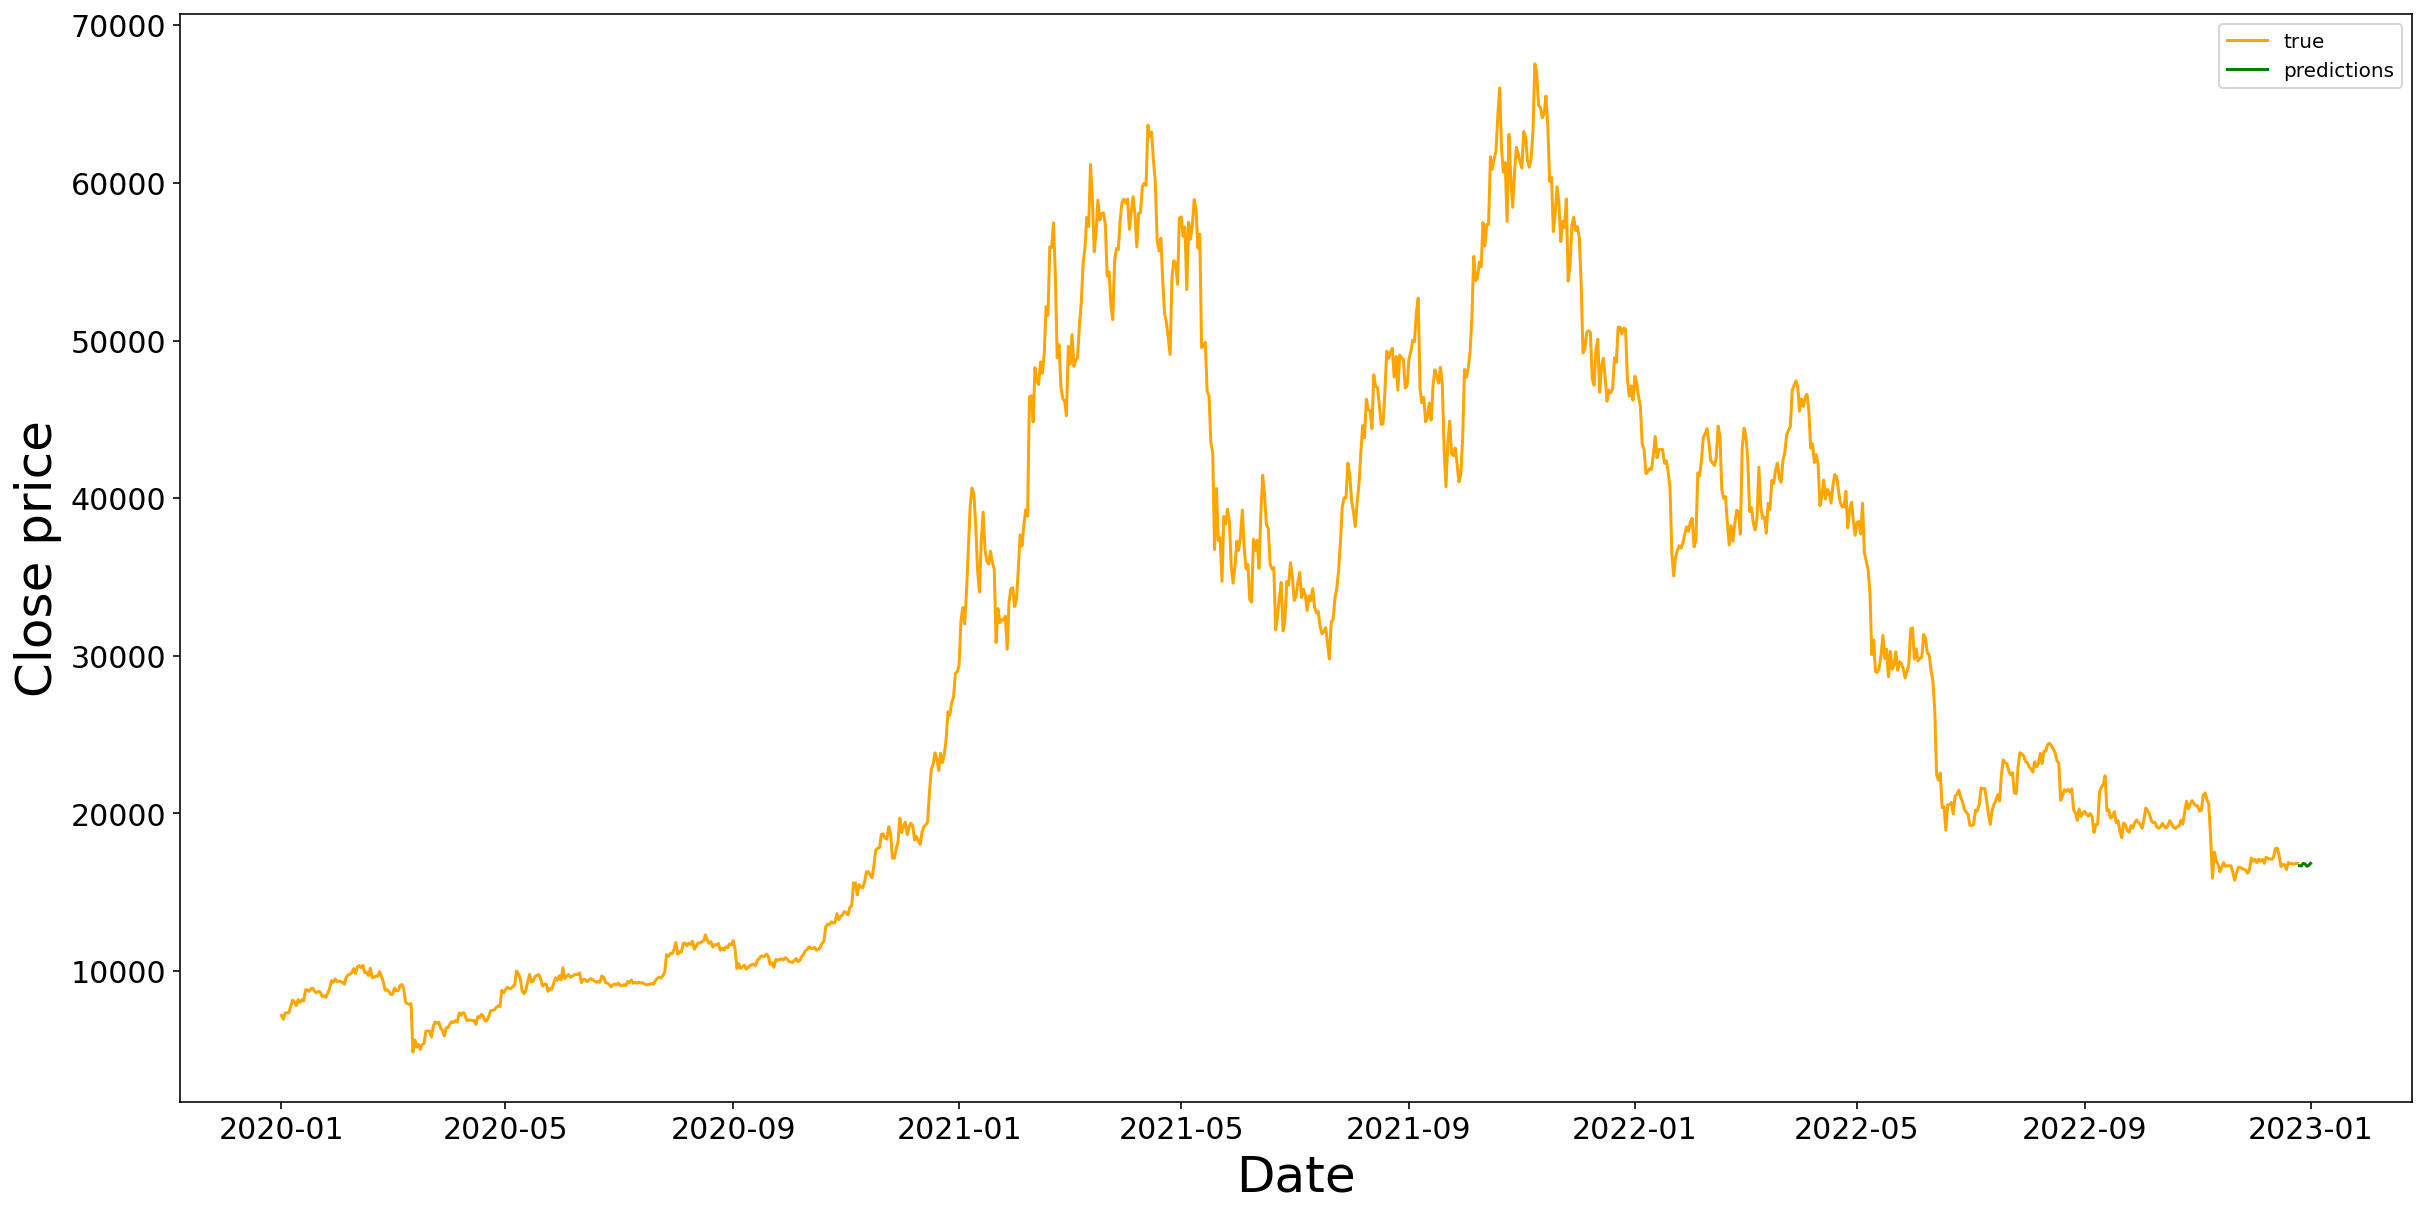

In [17]:
plt.plot(train_dates+val_dates, train+val, color = 'orange', label = 'true')
plt.plot(test_dates, y_pred_, color = 'green', label = 'predictions')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close price", fontsize = 25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

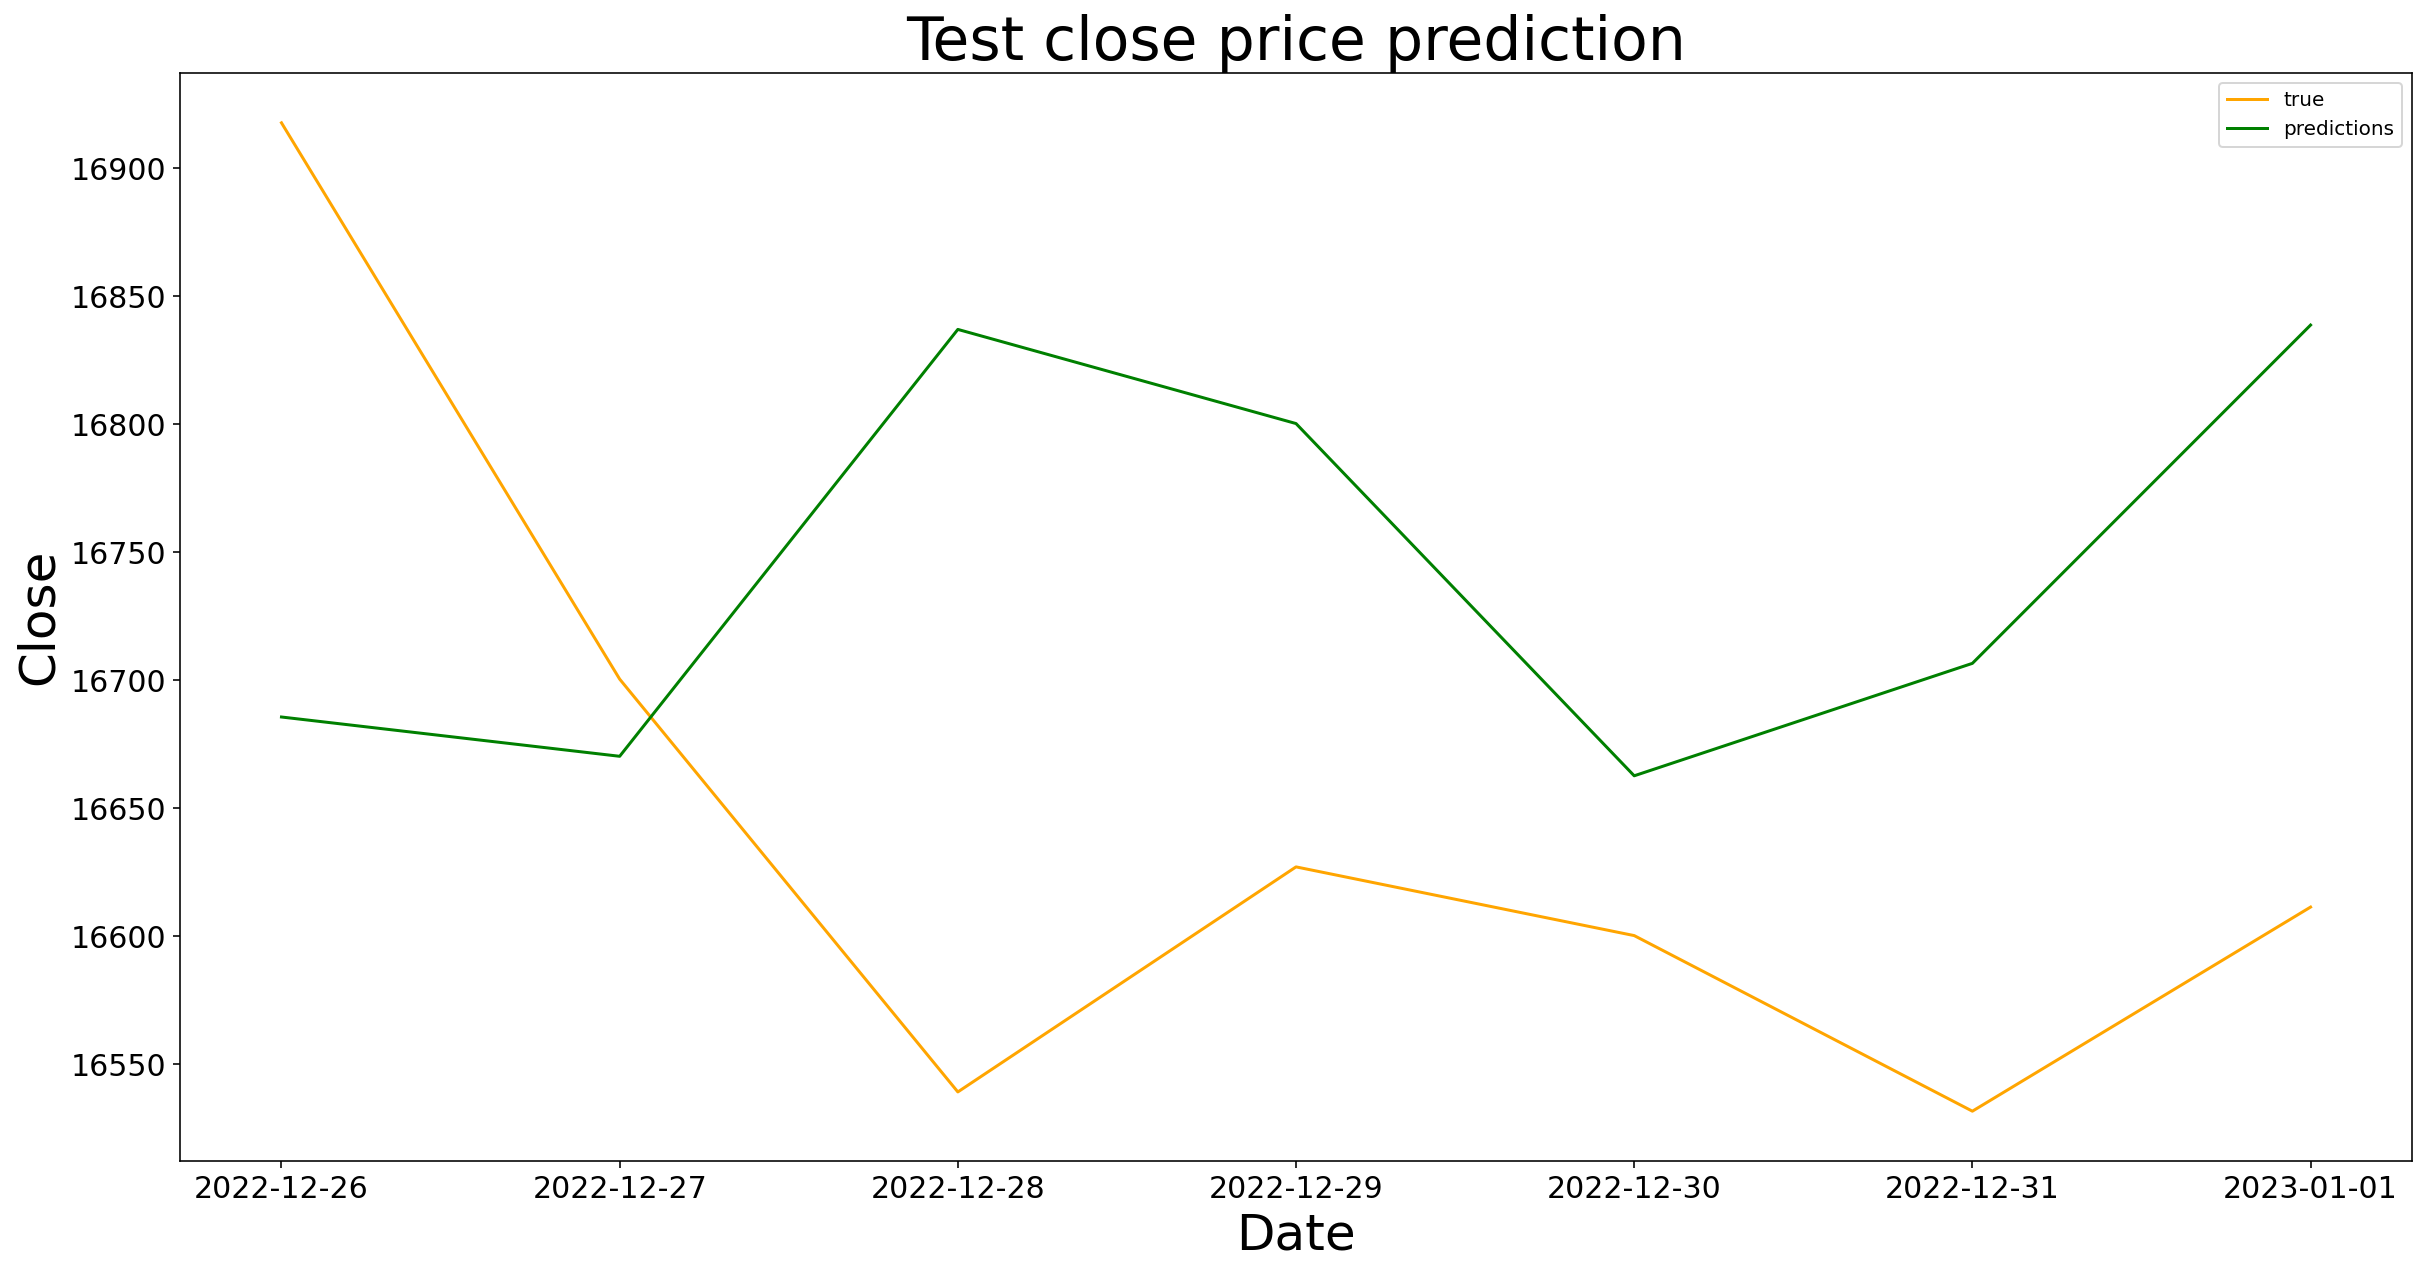

In [18]:
plt.plot(test_dates, test, color = 'orange', label = 'true')
plt.plot(test_dates, y_pred_, color = 'green', label = 'predictions')
plt.xlabel("Date", fontsize = 25)
plt.ylabel("Close", fontsize = 25)
plt.title("Test close price prediction", fontsize = 30)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend()
plt.show()

### Future prediction with best model. ###

In [19]:
best_order = arima_order
if RMSE < RMSE_:
    best_order = auto_arima_order

best_model = ARIMA(close, order=best_order).fit()
best_pred = best_model.forecast(period)
last_pred = best_pred[-1]
change_pred = (last_pred - close[-1]) / close[-1] * 100
print(f"Predicted price of {assets[0]} through {period} days = %.3f" % last_pred, sep="")
print(f"{assets[0]} change in percents = %.3f" % change_pred, '%', sep="")

Predicted price of bitcoin through 7 days = 16533.996
bitcoin change in percents = -0.466%
